# Création d'un scatter plot interactif

In [1]:
import sys

rootDir = "//ifb/data/mydatalocal"
projectDir = rootDir + "/VDBscratch"
libDir = projectDir + "/lib"
dataDir= "/ifb/data/public/teachdata/m2binf_ucbl/data" 

sys.path.append(libDir)

In [2]:
import pandas, uniprot, go
import numpy as np
from stat_utils import computeORA_BKG
# We use notebook backend to have interactivity support
%matplotlib notebook 

import matplotlib.pyplot as plt

#### Visualisation des abondances et Pathway pour chaque protéine
Nous allons représenter la relation entre l'abondance des protéines (**Log2 Corrected Abundance Ratio**)  et la précision de la mesure (**LOG10 Adj.P-val**). 
###### Creation du scatter plot
[matplotlib.axes.Axes.scatter()](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.scatter.html) permet d'intialiser le graphique.
###### Modification continue du scatter plot
Mais cette fonction retourne aussi un objet [PathCollection](https://matplotlib.org/3.1.1/api/collections_api.html) qui permet de modifier à posteriori le rendu des points du scatter plot.
###### Interactivité
L'affichage d'une figure via la méthode `fig.canvas.mpl_connect('EVENT_NAME', callbackFunction)` permet d'associer à [un évenement sur la figure](https://matplotlib.org/3.1.1/users/event_handling.html) l'execution du fonction (*callbackFunction*)

###### Illustration ci-dessous

<IPython.core.display.Javascript object>


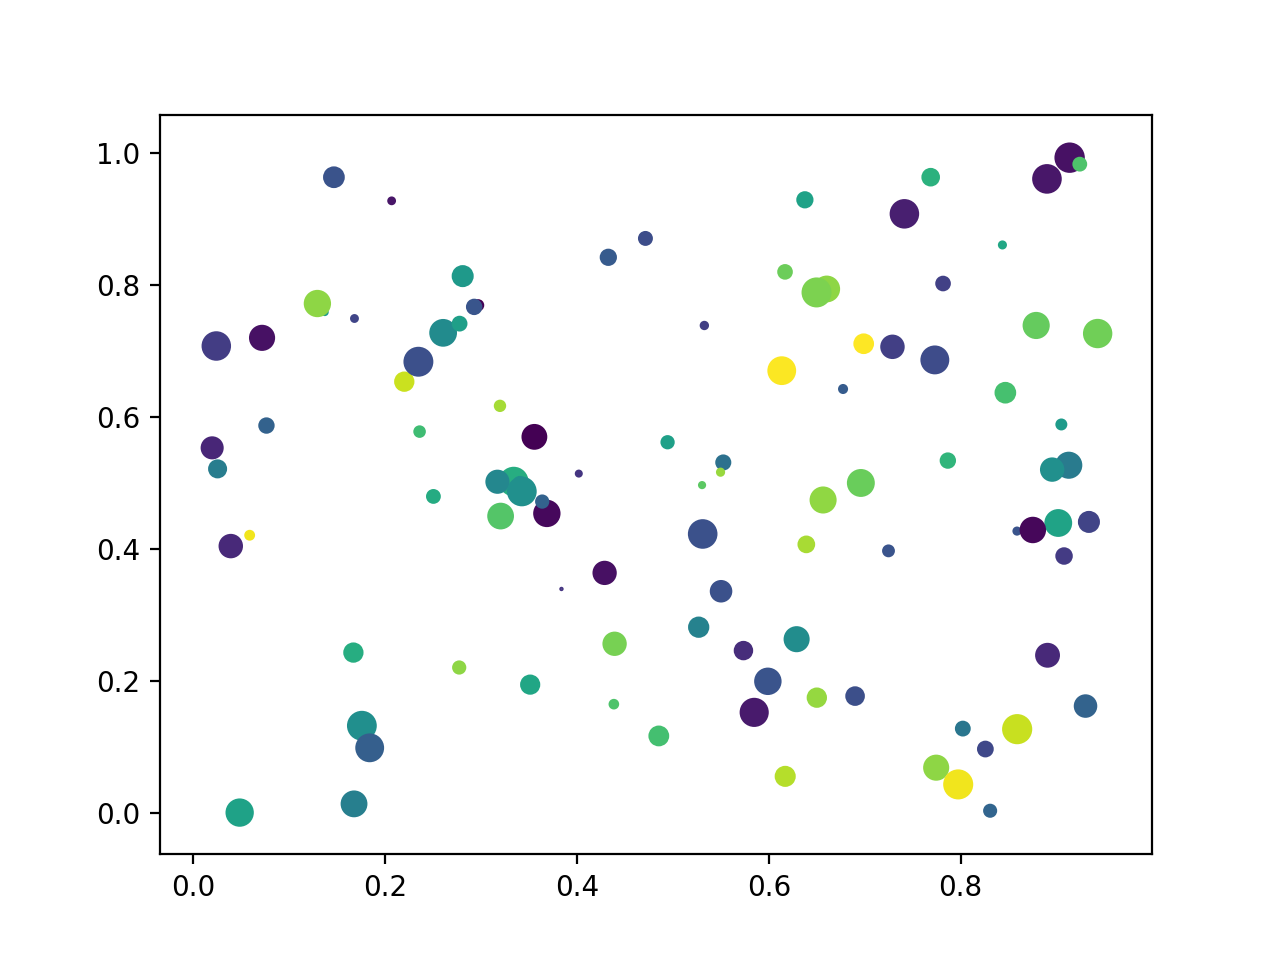

In [3]:
x, y, c, s = np.random.rand(4, 100)

def onclick(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    text.set_text(tx)
    col.set_sizes( np.random.rand(100) * 100 )
    
def onpick(event):
    ind = event.ind
    tx = str(ind)
    text.set_text(tx)
    col.set_sizes( np.random.rand(100) * 100 )
    col.set_color( np.full(100, 'tab:gray') )
    
fig = plt.figure()
ax1 = fig.add_subplot(111)
col = ax1.scatter(x, y, 100*s, c, picker=True)
text = ax1.text(0.5,1.1, "", va="bottom", ha="left")

#cid = fig.canvas.mpl_connect('button_press_event', onclick)
cid = fig.canvas.mpl_connect('pick_event', onpick)

### 3a Volcano plot interactif

##### Read-in data
* Array of protein names
* Array of abundace ratios
* Array of experimental pValue

In [4]:
import pandas
df=pandas.read_csv(projectDir + "/TCL_wt1.tsv", delimiter ="\t")

dfClean = df[ (df['Log2 Corrected Abundance Ratio'] != '#VALEUR!') & (df['LOG10 Adj.P-val'] != '#VALEUR!')]
dfClean = dfClean.copy()
dfClean.loc[:,'Log2 Corrected Abundance Ratio'] = dfClean.loc[:,'Log2 Corrected Abundance Ratio'].astype(float)
dfClean.loc[:,'LOG10 Adj.P-val'] = dfClean.loc[:,'LOG10 Adj.P-val'].astype(float)


saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()
allList = dfClean[ : ]['Accession'].tolist()
pvalue = dfClean[ : ]['LOG10 Adj.P-val'].tolist()

##### Dessiner un volcano plot qui affichera le nom de la protéine clickée

In [5]:
x,y, labels = (abundance, pvalue, allList)
def onpick(event):
    ind = event.ind
    tx = str(ind)
    msg = '\n'.join([ str(labels[i]) for i in ind ])
    text.set_text(msg)
    #print('onpick3 scatter:', ind, np.take(x, ind), np.take(y, ind))
 
fig = plt.figure()
ax1 = fig.add_subplot(111)
col = ax1.scatter(x, y, picker=True)

text = ax1.text(0, 7.5, "", va="bottom", ha="left")

cid = fig.canvas.mpl_connect('pick_event', onpick)

NameError: name 'abundance' is not defined

### 3b Intégration des annotations GO
#### Préambule 
1. Read-in data. **Attention** : Vous devez avoir collecté la liste des protéines de l'experience 
2. Réaliser *OverRepresentationAnalysis* sur le namespace GO de votre choix
    * exemple ci-dessous avec *biological process*

In [9]:
if not allList:
    raise ValueError('please read protein list from TSV')

GO_namespace = "biological process" # biological_process, molecular function, cellular component)
uniprotCollection = uniprot.UniprotCollection(dataDir +"/dataset")
K12 = uniprot.UniprotCollection(dataDir + "/K12_proteome/")
print("Loading ontology")
go.setOntology(dataDir + "/go.owl")


print(f"Extracting {GO_namespace} ontology")
xpGoTree_BP = go.AnnotationTree(GO_namespace, collapse=True)
xpGoTree_BP.extract(allList, uniprotCollection)


fullEcoliGoTree_BP = go.AnnotationTree(GO_namespace, collapse=True)
fullEcoliGoTree_BP.extract(K12.list, K12)


class Rankings():
    def __init__(self, oraResults, proteinList, title="Pathway ORA"):
        self.title = title
        self.ranks = [ ( d[0], d[1].name, len( set(d[1].getMembers()) & set(proteinList) ), len(proteinList) ) for d in sorted(oraResults, key=lambda x:x[0]) ]
    def _repr_html_(self):
        t_head = f"<h3>{self.title}</h3><table><thead><th>p-value</th><th>Pathway name</th><th>n</th></thead><tbody>"
        t_foot = '</tbody></table>'
        t_body = '</tr><tr>'.join([ '<td>' + '</td><td>'.join([ str(v) for v in pathwayScore ][:-1]) + '</td>' for pathwayScore in self.ranks ])
        t_body = '<tr>' + t_body + '</tr>'
        return t_head + t_body + t_foot
    
saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()
oraFisher, oraCDF = computeORA_BKG(xpGoTree_BP, saList, fullEcoliGoTree_BP)
rankingsObj = Rankings(oraFisher,saList, title=GO_namespace)
rankingsObj

Loading ontology
Loaded
Extracting biological process ontology
Applying true path collapsing
2194 leaves, 3482 nodes, 1474 proteins
Applying true path collapsing
2728 leaves, 6650 nodes, 3128 proteins
Evaluated 298 / 2194 Pathways, based on 44 proteins


3.0740143676824805e-06,siderophore transport,5
1.4333376891745052e-05,iron coordination entity transport,5
2.9305999920744405e-05,protein insertion into membrane,4
3.1801614970675325e-05,membrane organization,5
5.221318723734416e-05,Gram-negative-bacterium-type cell outer membrane assembly,4
5.221318723734416e-05,membrane assembly,4
6.758963970377286e-05,establishment of protein localization to membrane,4
0.0001285368129330478,iron ion transport,5
0.00019634523788932085,ion transport,13
0.00023663274449265561,protein localization to membrane,4
0.0002536535809632806,macromolecule localization,8



###### Pour chaque Terme GO que vous souhaitez representer dans le volcano plot
###### Lister toutes les protéines (feuilles) de ce terme (sous-arbre)

```python
list (set (xpGoTree_BP.getByName(goTermName).getMembers() )
```

### Puis, au choix
* Colorier les protéines des n Pathway les plus représentés dans le namespace GO de votre choix (biological_process, molecular function, cellular component): **utiliser des palettes de couleurs catégorielles**. Priorités sera donné au pathway avec le meilleur score ORA.
* Dessiner un volcano plot qui coloriera d'une même couleur les protéines appartenant au pathway GO de la protéine clickée
* Dessiner un volcano plot qui fera disparaitre les protéines n'appartenant au même pathway GO de la protéine clickée

['P77774', 'P0A903', 'P0ADC1', 'P31554', 'P76445', 'P0ADV9', 'P0AEU7', 'P66948', 'P0ADV1', 'P0AC02', 'P0A940', 'P0ABZ6', 'P0A937']
['P0AGA2', 'P0ADV7', 'P25714', 'P0A940', 'P0A937', 'P0ADC1', 'P31554', 'P43671', 'P0ADV9', 'P0ADV1', 'P0ABZ6', 'P0A903', 'P76445', 'P0AEU7', 'P0AG99', 'P77774', 'P60752', 'P76506', 'P66948', 'P0AC02']
['P77774', 'P0AGA2', 'P0A903', 'P25714', 'P0AEU7', 'P0AG99', 'P0AC02', 'P0A940', 'P0A937']
['P05825', 'P02930', 'P69490', 'P76115', 'P13036', 'P15028', 'P0AEL6', 'P75780', 'P06971', 'P23878']
['P05825', 'P02930', 'P13036', 'P76115', 'P75780', 'P0AEL6', 'P06971', 'P23878']
['P75936', 'P76231', 'P0A8S9', 'P05706', 'P29744', 'P0A9A2', 'P75937', 'P43533', 'P0ABR1', 'P26608']
['tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray']
[4.260067469, 3.45462743, 4.571899347, 1.699767669, 1.434786589, 2.887197633, 6.154103778, 2.878506676, 0.328873724, 0.277155457]
[-3.721334942, -3.429568818, -3.284695189, 

<IPython.core.display.Javascript object>


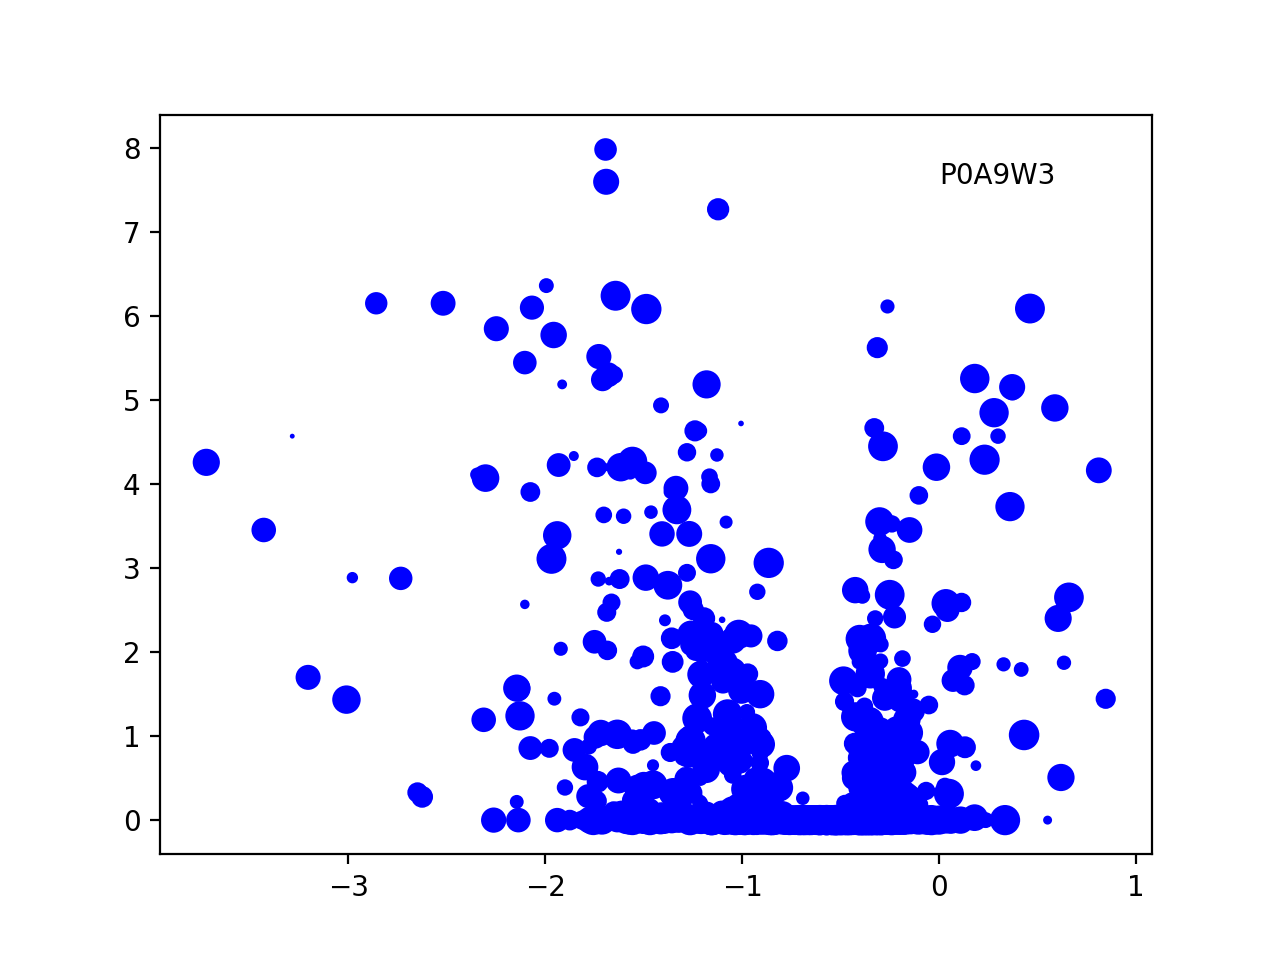

In [10]:
colors =  ['b', 'g', 'r', 'c', 'm', 'y', 'k']

color_node = [ 'tab:gray' for n in allList ]


# Get (n)5th first subbtrees
goNames = ["siderophore transport", "iron coordination entity transport", "protein insertion into membrane", "membrane organization", "Gram-negative-bacterium-type cell outer membrane assembly"]
for iColor,goName in enumerate(reversed(goNames)):
    cur_color = colors[iColor]
    proteinID = list (set (xpGoTree_BP.getByName(goName).getMembers() ))
    print(proteinID)
    for p in proteinID:
        iProt = allList.index(p)
        color_node[iProt] = cur_color
        
print(f"{allList[:10]}\n{color_node[:10]}\n{pvalue[:10]}\n{abundance[:10]}")

x,y, labels = (abundance, pvalue, allList)
def onpick(event):
    ind = event.ind
    tx = str(ind)
    msg = '\n'.join([ str(labels[i]) for i in ind ])
    text.set_text(msg)
    #print('onpick3 scatter:', ind, np.take(x, ind), np.take(y, ind))
    
def onpickUpdate(event):
    ind = event.ind
    tx = str(ind)
    msg = '\n'.join([ str(labels[i]) for i in ind ])
    text.set_text(msg)
    col.set_color(['b' for x in allList])
    col.set_sizes( np.random.rand(len(allList)) * 100 )#np.random.rand(4, 100)
    # col is a https://matplotlib.org/3.1.1/api/collections_api.html
 
fig = plt.figure()
ax1 = fig.add_subplot(111)
#col = ax1.scatter(x, y, 100*s, c, picker=True)

col = ax1.scatter(x, y, c=color_node, picker=True)

text = ax1.text(0, 7.5, "", va="bottom", ha="left")
#fig.savefig('pscoll.eps')
cid = fig.canvas.mpl_connect('pick_event', onpickUpdate)